In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [2]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Check that gradients can flow across channel:

In [3]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.01475713 0.3816747  0.5935042  0.01006398]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [4]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [7]:
inputs, targets = generate_train_batch()

In [8]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

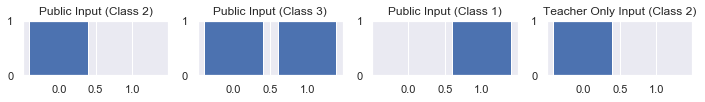

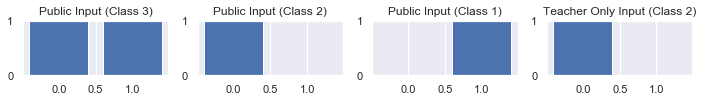

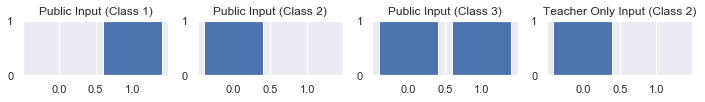

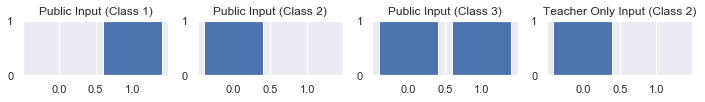

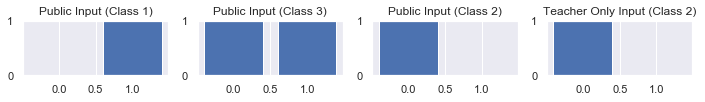

In [9]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [10]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[4, 1, 2, 3],
       [1, 3, 0, 2],
       [3, 0, 2, 1],
       [1, 0, 4, 2],
       [2, 4, 3, 0]], dtype=int64)>

## Create Data-Specific Input Encoder

In [11]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 16

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [12]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0.5)

    loss = combined_loss_fn(outputs, targets)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 0.05312471091747284
agent/dense/bias:0 teacher grad norm: 0.043473020195961
agent/lstm/kernel:0 teacher grad norm: 0.07711490988731384
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.015017852187156677
agent/lstm/bias:0 teacher grad norm: 0.0374174565076828
agent/dense_1/kernel:0 teacher grad norm: 0.03713128715753555
agent/dense_1/bias:0 teacher grad norm: 0.053739432245492935

agent/dense_2/kernel:0 student grad norm: 2.1721320152282715
agent/dense_2/bias:0 student grad norm: 2.527498960494995
agent/lstm_1/kernel:0 student grad norm: 3.6696560382843018
agent/lstm_1/recurrent_kernel:0 student grad norm: 1.1241791248321533
agent/lstm_1/bias:0 student grad norm: 2.973846673965454
agent/dense_3/kernel:0 student grad norm: 1.6008548736572266
agent/dense_3/bias:0 student grad norm: 3.34671950340271


In [13]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  4480      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  1235      
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [14]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=1, 
                    channel_size=CHANNEL_SIZE,
                    kind_mutations=False,
                    training=False)

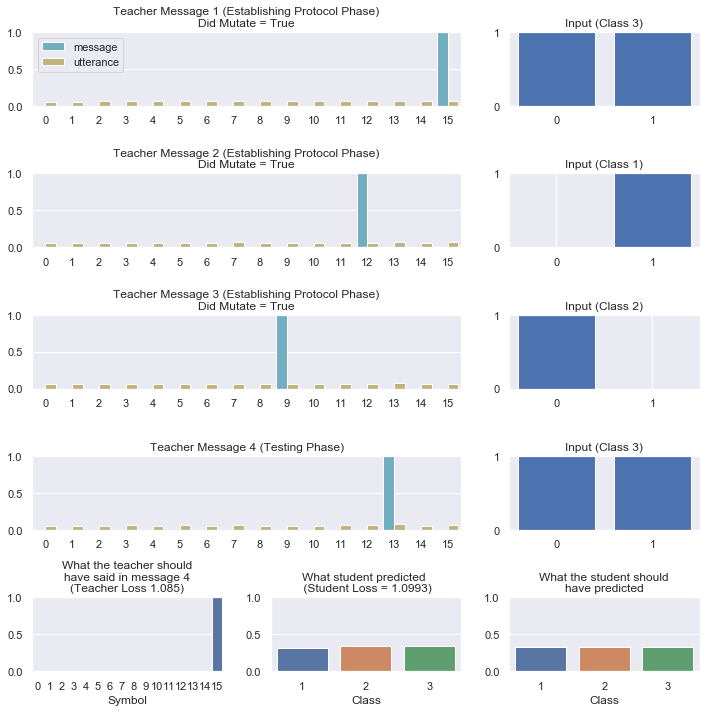

In [15]:
plot_game(inputs, outputs, targets, select_batch=6, fig_width=6)

In [16]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 1.1563197374343872
agent/dense/bias:0 teacher grad norm: 1.0574761629104614
agent/lstm/kernel:0 teacher grad norm: 1.770711898803711
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.21679657697677612
agent/lstm/bias:0 teacher grad norm: 0.9247792959213257
agent/dense_1/kernel:0 teacher grad norm: 0.8235467076301575
agent/dense_1/bias:0 teacher grad norm: 1.7490850687026978


# Run Experiments

In [17]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct,
        name='only_student_experiment'
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class,
        name='only_teacher_test_msg_experiment'
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o),
        name='only_teacher_create_protocol_experiment'
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn,
        name='other_play_experiment'
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        name='other_play_separate_optimise_experiment'
    )

def create_self_play_experiment(p_mutate=0.3, epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='self_play_experiment'
    )

In [18]:
experiment = create_self_play_experiment(epochs=100)
print(experiment.get_config())

{'name': 'self_play_experiment', 'max_epochs': 100, 'steps_per_epoch': 50, 'epochs_optimised': 0, 'loss_fn': 'complete_loss_fn', 'play_params': {'channel_size': 16, 'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.01, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}


In [19]:
experiment.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 100, 'steps_per_epoch': 50, 'epochs_optimised': 100, 'loss_fn': 'complete_loss_fn', 'play_params': {'channel_size': 16, 'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}
Epoch 0, Time Taken (mm:ss): 0:12, Mean Loss: 4.445
Test Loss: 4.332, Ground Truth F1-Score: 0.328, Student Error: 1.109, Teacher Error: 0.848, Protocol Diversity: 0.473,
Epoch 1, Time Taken (mm:ss): 0:12, Mean Loss: 4.395
Epoch 2, Time Taken (mm:ss): 0:10, Mean Loss: 4.361
Epoch 3, Time Taken (mm:ss): 0:10, Mean Loss: 4.322
Epoch 4, Time Taken (mm:ss): 0:10, Mean Loss: 4.313
Epoch 5, Time Taken (mm:ss): 0:10, Mean Loss: 4.168
Test Loss: 4.217, Ground Truth F1-Score: 0.341, Student Error: 1.097, Teacher Error: 0.74, Protocol Diversity: 0.471,
Epoch 6, Tim

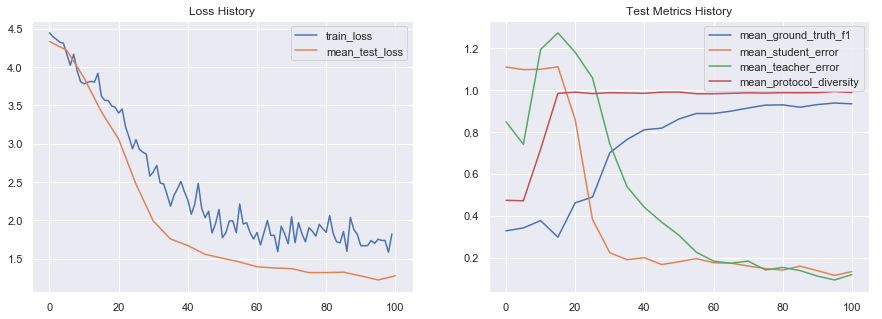

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in experiment.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * experiment.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=f'{metric}',
                 ax=ax)

In [20]:
experiment2 = create_self_play_experiment()

In [21]:
experiment2.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 40, 'steps_per_epoch': 50, 'epochs_optimised': 0, 'loss_fn': 'complete_loss_fn', 'play_params': {'channel_size': 16, 'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}
Training stopped.


In [ ]:
axs = experiment.plot_training_history()
experiment2.plot_training_history(axs=axs)

## Render Model Graph in Tensorboard

In [ ]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)

# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [ ]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [28]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.2505943775177002,
 'mean_ground_truth_f1': 0.9375,
 'mean_student_error': 0.11420788615942001,
 'mean_teacher_error': 0.10763619095087051,
 'mean_protocol_diversity': 0.9856250286102295}

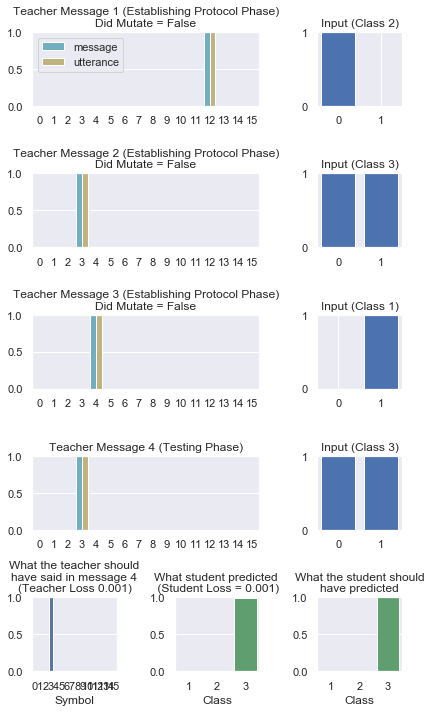

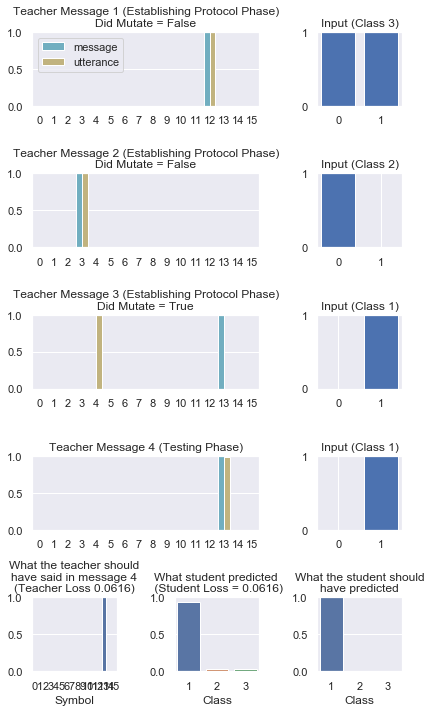

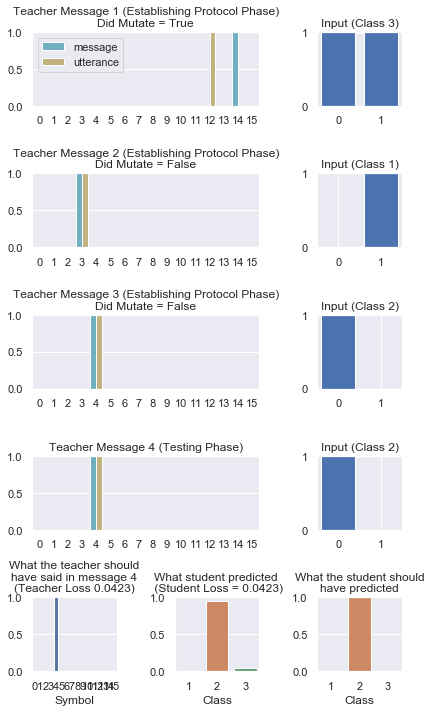

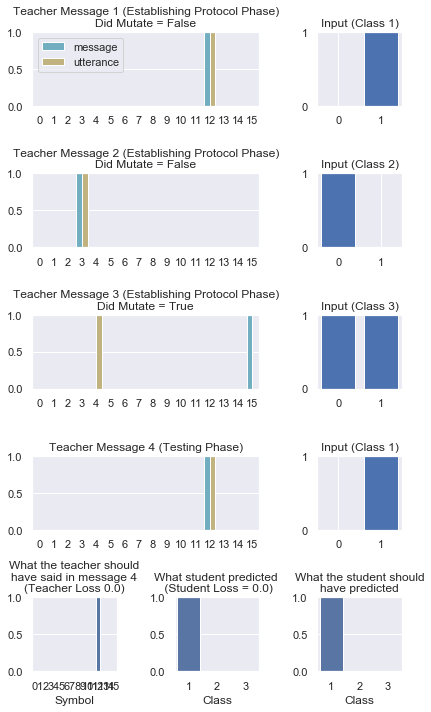

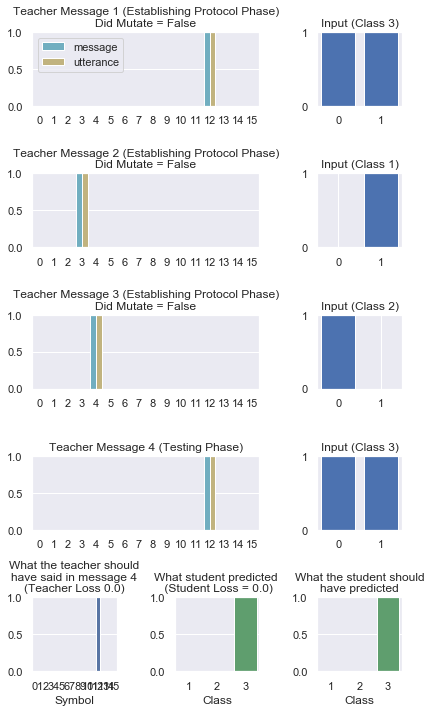

In [29]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

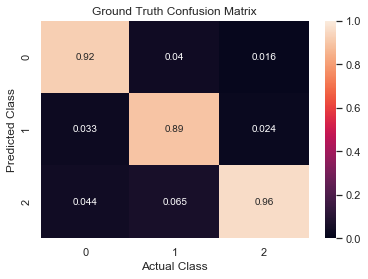

In [32]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

In [ ]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

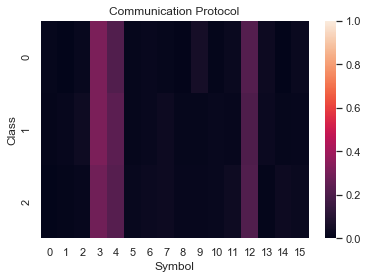

In [35]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [ ]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

## Zero-shot Coordination

In [ ]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)

teacher_error, protocol_diversity = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Protocol Diversity {protocol_diversity}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

In [ ]:
plot_game(inputs, outputs, targets, select_batch=1)

In [ ]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)

teacher_error, protocol_diversity = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Protocol Diversity {protocol_diversity}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

In [ ]:
plot_game(inputs, outputs, targets)